In [1]:
from importlib import reload
import flymovie as fm
import cnn_models
import cnn_models.siamese_cnn as cn
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pickle
from pathlib import Path
import scipy.spatial
import scipy.ndimage as ndi
import tensorflow as tf
from importlib import reload
%load_ext autoreload
%autoreload 2

## Goals

1. Design a test for the performance of an embedding

2. Design a way to apply curriculum learning to my siamese CNN network.


### 1. Designing a test for the performance of an embedding

My strategy is to first construct a test set of images, feed those images through a candidate embedding, and determine the success of the network based on how well similar images are clustered together. Some options:
    - top N accuracy: how often is the most-similar non-self image in the top N
    - Mean ranking of top N: rank images by actual similarity (based on sim parameters), rank them by embedding distance, compare. I think I'll start with just the sum of the squared rank differences. I can probably adapt this to be something with useful statistical properties eventually but no need right now.


In [24]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ/checkpoint_testmodel'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=18)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [33]:
from cnn_models.siamese_cnn import preprocess_image

############################################################################
def embed_images(im_folder, embedding, mip=False):
    """Pass images from a folder through embedding, return their location 
    and simulation parameters."""
    
    def normalize_params(params):
        std = np.std(params, axis=0)
        # If the parameter is fixed it will have std=0. Since the difference
        # will be 0 and the desired value is all 0, any non-zero value for 
        # std works to avoid divide by 0 error.
        std[std == 0] = 1e6
        p = params.copy()
        p = (p - p.mean(axis=0)) / std
        return p
        
    ims = []
    files = os.listdir(im_folder)
    num_params = len(files[-1].split('_')) - 2
    params = np.ndarray((0, num_params))

    # Load images and extract parameters.
    for f in files:
        if f[3] != '_':
            continue
        # Because of the silliness with extracting filename from tensor, 
        # have to add two single quotes flanking filename.
        filename = "_'" + os.path.join(im_folder, f) + "'_"
        im = preprocess_image(filename, mip)
        ims.append(im)
        p= f.split('_')[1:-1]
        p = [float(x) for x in p]
        params = np.vstack([params, p])
    
    params = normalize_params(params)

    # Calculate embedding for each image.
    im_embeddings = np.ndarray((0,256))
    for i in range(len(ims)):
        im = ims[i]
        im = np.expand_dims(im, axis=0)
        e = embedding(im).numpy()
        im_embeddings = np.vstack([im_embeddings, e])
        
    return im_embeddings, params

############################################################################
def sort_by_distance(data, n):
        ref = data[n, :]
        f = lambda x: scipy.spatial.distance.euclidean(x, ref)
        dists = np.apply_along_axis(f, 1, data)
        indxs = np.argsort(dists)
        return indxs[1:]

############################################################################
def top_n_accuracy(im_embeddings, params, n):
    if im_embeddings.shape[0] != params.shape[0]:
        raise ValueError('Row number does not match.')
    
    num_images = im_embeddings.shape[0]
    rank_sq_diff_sums = []
    best_in_topn_count = 0

    for i in range(num_images):
        embedding_dist = sort_by_distance(im_embeddings, i)
        param_dist = sort_by_distance(params, i)
        best_idx = param_dist[0]
        if best_idx in embedding_dist[:n]:
            best_in_topn_count += 1
        rank_sq_diff_sum = np.sum((embedding_dist[:n] - param_dist[:n]) ** 2)
        rank_sq_diff_sums.append(rank_sq_diff_sum)
    
    accuracy = best_in_topn_count / num_images
    print('Top ' + str(n) + ' accuracy: ' + str(accuracy))
    rank_sq_diff_mean = np.mean(rank_sq_diff_sums)
    print('Top ' + str(n) + ' rank square difference mean: ' + str(rank_sq_diff_mean))

############################################################################       
def visualize_batch(ds, figsize=4):
    def process_im(arr):
        im = np.squeeze(arr)
        return (im - np.min(im)) / (np.max(im) - np.min(im)) * 1000
    iter = ds.as_numpy_iterator()
    batch = next(iter)
    im1 = process_im(batch[0])
    im2 = process_im(batch[1])
    im3 = process_im(batch[2])
    fm.viewer([im1, im2, im3], figsize)

In [41]:
im_embeddings, params = embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_AdBkIaWE', embedding)

(10, 256)

In [92]:
top_n_accuracy(im_embeddings, params, 5)

Top 5 accuracy: 0.9
Top 5 rank square difference mean: 72.4


In [101]:
top_n_accuracy(np.random.random((150,10)), np.random.random((150,10)), 5)

Top 5 accuracy: 0.013333333333333334
Top 5 rank square difference mean: 19656.12


### 2. Refactoring siamese cnn to use curriculum learning



In [104]:
# Set up input directories.
from pathlib import Path
folder = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir=folder
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [195]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

negative_images = anchor_images + positive_images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)   

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset)) 
#dataset = dataset.shuffle(buffer_size=1024)

### Below is the new strategy

No longer use shuffling of negative dataset. Start by pairing files (as lists). Will do a scheme where it accepts some parameter (num_negative_pairs maybe) and for each AP pair, generates that many negative pairings that are within some margin in parameter distance. The result will be three ordered lists. Make three datasets from these, zip them, shuffle, and use the take method to select subset.

This way I generate num_images * num_negative_pairs possible APN filename pairings, Randomly sample from those for training sets.

Basically: first generate an excess number of triplets that satisfy margin, randomly sample from those as opposed to doing the shuffling online.

## Goals 2022-02-14

1. Implement the above

2. Comment and test cnn module (ugh). Get it in order.

In [214]:
a = np.arange(1000)
n = np.arange(2000)
a_dataset = tf.data.Dataset.from_tensor_slices(a)
p_dataset = tf.data.Dataset.from_tensor_slices(a)
n_dataset = tf.data.Dataset.from_tensor_slices(n)

dataset = tf.data.Dataset.zip((a_dataset, p_dataset, n_dataset)) 
dataset = dataset.shuffle(5000)
dataset = dataset.take(1)


In [230]:
count = 0

for i in dataset:
    print(i)

(<tf.Tensor: shape=(), dtype=int64, numpy=902>, <tf.Tensor: shape=(), dtype=int64, numpy=902>, <tf.Tensor: shape=(), dtype=int64, numpy=902>)


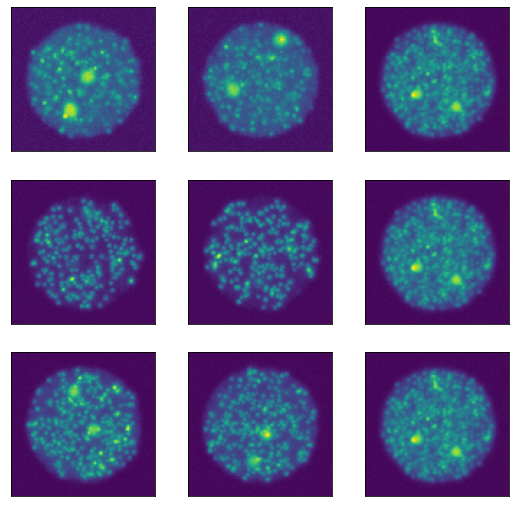

In [144]:
iter = dataset.as_numpy_iterator()

def show(ax, image):
        ax.imshow(image, vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    a = next(iter)
    show(axs[i, 0], a[0].max(axis=0))
    show(axs[i, 1], a[1].max(axis=0))
    show(axs[i, 2], a[2].max(axis=0))

In [4]:
#cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_uPoNivMJ')
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_715_ylolCRqp')
left = cache_dir / 'left'
right = cache_dir / 'right'
anchor = sorted(
        [str(left / f) for f in os.listdir(left)]
    )

positive = sorted(
        [str(right / f) for f in os.listdir(right)]
    )


list

In [40]:
def fake_files(n):
    l = []
    for _ in range(n):
        f = 'aaa'
        for _1 in range(9):
            f = f + '_' + str(np.random.randint(0,100))
        f = f + '_rep0.pkl'
        l.append(f)
    return l

anchor = fake_files(10_000)
positive = fake_files(10_000)

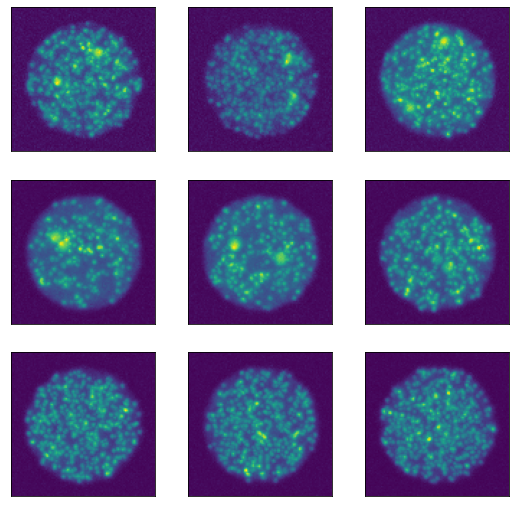

In [218]:
rand_indxs = np.random.randint(0,len(a), 3)

def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(9, 9))

axs = fig.subplots(3, 3)
for i in range(3):
    im_a = fm.load_pickle(a[rand_indxs[i]])
    im_p = fm.load_pickle(p[rand_indxs[i]])
    im_n = fm.load_pickle(n[rand_indxs[i]])
    show(axs[i, 0], im_a.max(axis=0))
    show(axs[i, 1], im_p.max(axis=0))
    show(axs[i, 2], im_n.max(axis=0))

    

In [28]:
cache_dir = Path('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/testsims_715_ylolCRqp')
left = cache_dir / 'left'
right = cache_dir / 'right'
anchor = sorted(
        [str(left / f) for f in os.listdir(left)]
    )

positive = sorted(
        [str(right / f) for f in os.listdir(right)]
    )

train, val = cn.make_triplet_inputs(cache_dir, lower_margin=98, upper_margin=100, num_negatives=5)

In [32]:
visualize_batch(train)

interactive(children=(Dropdown(description='Color', index=4, options=('prism', 'magma', 'Reds', 'viridis', 'ci…

In [114]:
import tempfile

os.makedir()

AttributeError: module 'os' has no attribute 'makedir'

In [ ]:
sysTemp = tempfile.gettempdir()
myTemp = os.path.join(sysTemp,'mytemp')

#You must make sure myTemp exists
if not os.path.exists(myTemp):
    os.makedirs(myTemp)


In [191]:
from flymovie.load_save import save_pickle
from cnn_models.siamese_cnn import make_triplet_inputs

with tempfile.TemporaryDirectory() as topdir:
    print(topdir)
    os.mkdir(os.path.join(topdir, 'left'))
    os.mkdir(os.path.join(topdir, 'right'))

    im = np.ones((10,20,20))
    im1 = im.copy()
    im1[0,0,0] = 10
    im2 = im.copy()
    im2[0,0,1] = 10
    save_pickle(im1, os.path.join(topdir, 'left', 'aaa_10_10_10_10_10_10_10_10_10_rep0.pkl'))
    save_pickle(im1, os.path.join(topdir, 'right', 'aaa_10_10_10_10_10_10_10_10_10_rep1.pkl'))
    save_pickle(im1, os.path.join(topdir, 'left', 'bbb_9_9_9_9_9_9_9_9_9_rep0.pkl'))
    save_pickle(im1, os.path.join(topdir, 'right', 'bbb_9_9_9_9_9_9_9_9_9_rep1.pkl'))
    save_pickle(im2, os.path.join(topdir, 'left', 'ccc_1_1_1_1_1_1_1_1_1_rep0.pkl'))
    save_pickle(im2, os.path.join(topdir, 'right', 'ccc_1_1_1_1_1_1_1_1_1_rep1.pkl'))
    save_pickle(im2, os.path.join(topdir, 'left', 'ddd_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_rep0.pkl'))
    save_pickle(im2, os.path.join(topdir, 'right', 'ddd_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_1.5_rep1.pkl'))
    cache_dir = Path(topdir)
    train_dataset, val_dataset = make_triplet_inputs(cache_dir, lower_margin=0, upper_margin=45, num_negatives=1, 
        n_repeats=1, mip=False, batch_size=1, rotate=False)
    for batch in train_dataset:
        print('batch')

    for batch in val_dataset:
        print('v')
    
    for batch in train_dataset:
        print(batch[0][0,0,0,0,0])
        print(batch[2][0,0,0,0,0])
        print('')

    for batch in val_dataset:
        print(batch[0][0,0,0,0,0])
        print(batch[2][0,0,0,0,0])
        print('')
    """
    for batch in val_dataset:
        print(batch[0][0,0,0,1,0])
        print(batch[1][0,0,0,1,0])
        print(batch[2][0,0,0,1,0])
        print('')
    """
    #visualize_batch(train_dataset)


/var/folders/46/dftvy0sd0jv10kyqlkqc2d8m0000gn/T/tmppx7fqpo8
batch
batch
batch
v
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)



In [101]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  #if epoch < 10:
  #  return lr
  #else:
    return lr * 0.9#tf.math.exp(-0.1)

model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
round(model.optimizer.lr.numpy(), 5)


0.01

In [113]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=1, callbacks=[callback], verbose=0)
round(model.optimizer.lr.numpy(), 5)


0.00282

In [239]:
anchor_files = ['abc', 'def']
ds = tf.data.Dataset.from_tensor_slices(anchor_files)
def f(x):
    print(x)
    fm.load_pickle(x)
    return x
def process(x):
    
    x = tf.py_function(f, [x,], [tf.string,])
    return x
_ = ds.map(process)

/Users/michaelstadler/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [240]:
for i in ds:
    print(i)

tf.Tensor(b'abc', shape=(), dtype=string)
tf.Tensor(b'def', shape=(), dtype=string)
